In [7]:
pip install fredapi pandas matplotlib

Note: you may need to restart the kernel to use updated packages.


In [8]:
import yfinance as yf
import matplotlib.pyplot as plt

[*********************100%***********************]  1 of 1 completed


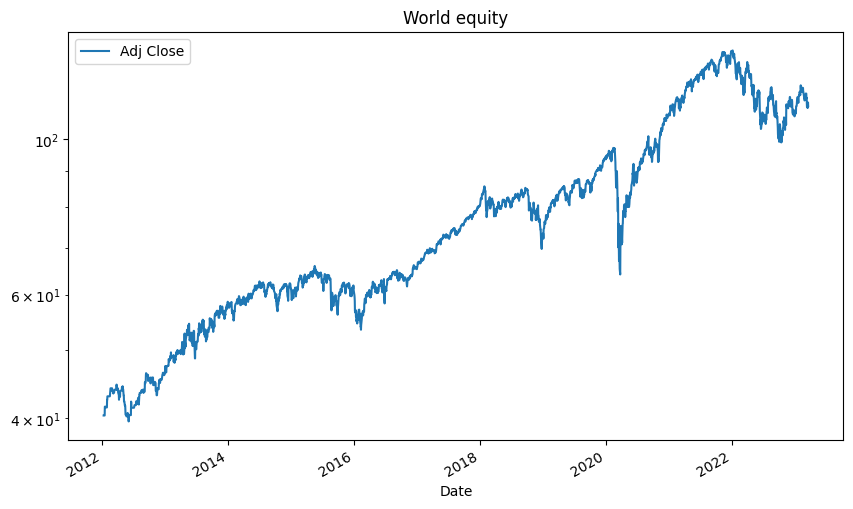

In [4]:
# Download historical data for the ETFs
data = yf.download('URTH', start='2000-01-01')['Adj Close']

# Plot the ETFs in a logarithmic scale
fig, ax = plt.subplots(figsize=(10, 6))
data.plot(ax=ax, logy=True)

# Add a legend
plt.title("World equity")
plt.legend()
# Show the plot
plt.show()

[*********************100%***********************]  6 of 6 completed


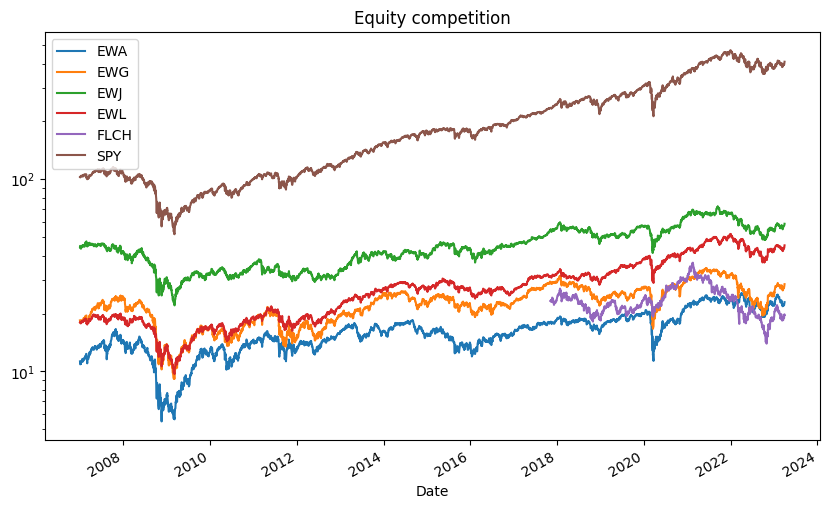

In [86]:
tickers = ['SPY', 'EWJ', 'EWG', 'EWA', 'EWL', 'FLCH']


#SPY -> US, EWJ -> Japan, EWL -> switzerland, EWA -> Australia, MCHI -> China, 

# Download historical data for the ETFs
data = yf.download(tickers, start='2007-01-01')['Adj Close']

# Normalize the data
normalized_data = data / data.iloc[0] * 100

# Plot the ETFs in a logarithmic scale
fig, ax = plt.subplots(figsize=(10, 6))
data.plot(ax=ax, logy=True)

# Add a legend
plt.title("Equity competition")
plt.legend()
# Show the plot
plt.show()

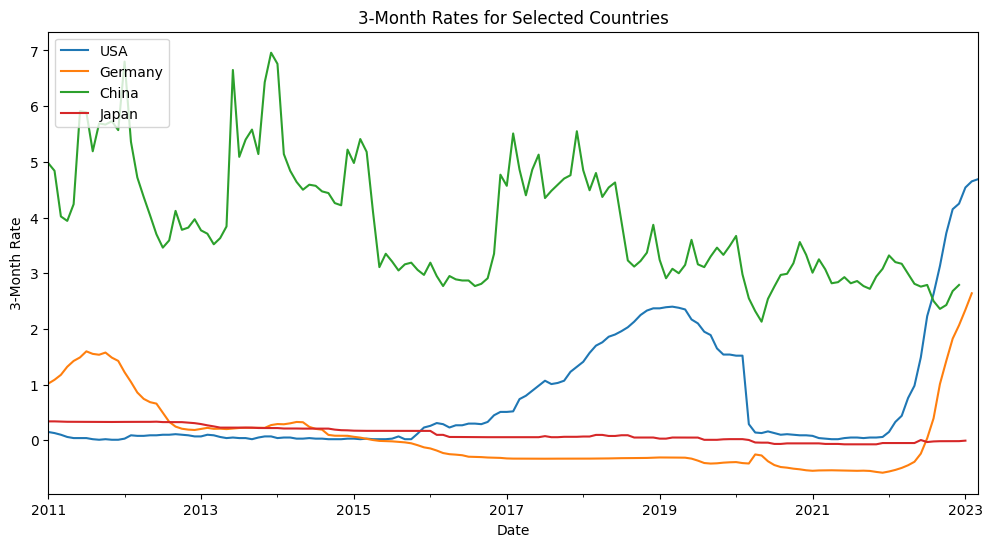

[*********************100%***********************]  4 of 4 completed
               USA   Germany   China     Japan
2011-01-01  0.0015  0.010172  0.0498  0.003400
2011-02-01  0.0013  0.010867  0.0484  0.003400
2011-03-01  0.0010  0.011755  0.0402  0.003361
2011-04-01  0.0006  0.013212  0.0394  0.003329
2011-05-01  0.0004  0.014251  0.0424  0.003321
...            ...       ...     ...       ...
2022-11-01  0.0415  0.018252  0.0268 -0.000160
2022-12-01  0.0425  0.020663  0.0279 -0.000150
2023-01-01  0.0454  0.023449     NaN -0.000060
2023-02-01  0.0465  0.026403     NaN       NaN
2023-03-01  0.0469       NaN     NaN       NaN

[147 rows x 4 columns]


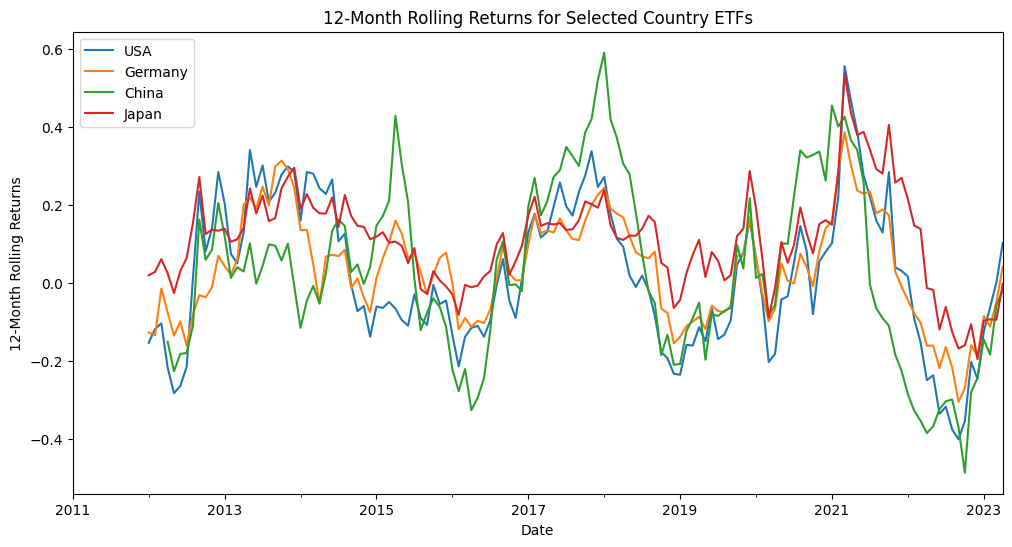

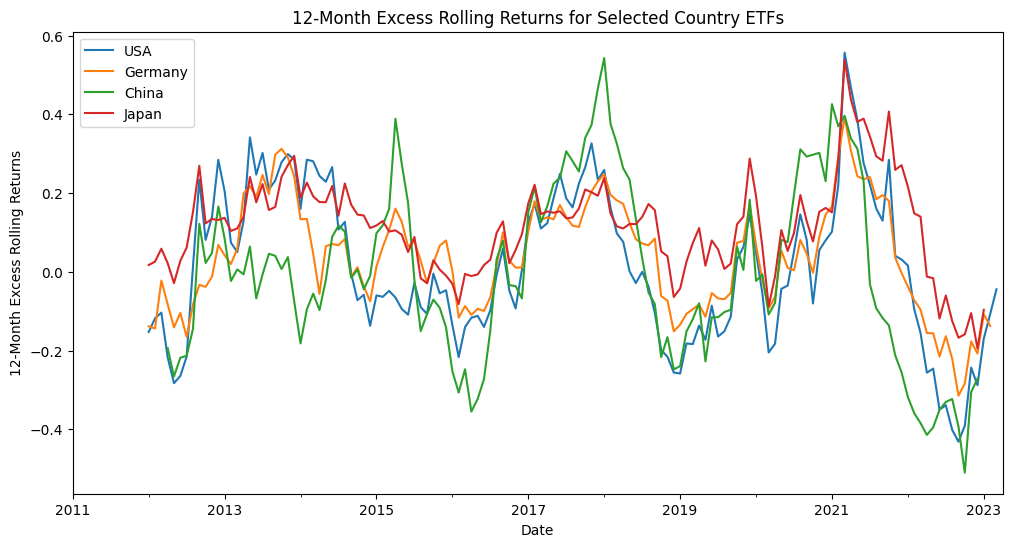

In [144]:
import pandas as pd
import matplotlib.pyplot as plt
from fredapi import Fred

# Set your FRED API key
api_key = "2f15c96b46530fde1b1992a64c64650e"
fred = Fred(api_key=api_key)

# Define the FRED series IDs for each country's 3-month rate
country_series = {
    "USA": "TB3MS",
    "Germany": "IR3TIB01DEM156N",
    "China": "IR3TIB01CNM156N",
    "Japan": "IR3TIB01JPM156N"
}

# Specify the start date for the series
start_date = "2011-01-01"

# Download 3-month rate data for each country
country_data = {}
for country, series_id in country_series.items():
    country_data[country] = fred.get_series(series_id, start_date)
    
# Combine the data into a single DataFrame
combined_data = pd.concat(country_data, axis=1)

# Plot the 3-month rates
combined_data.plot(figsize=(12, 6))
plt.xlabel("Date")
plt.ylabel("3-Month Rate")
plt.title("3-Month Rates for Selected Countries")
plt.legend(loc="upper left")
plt.show()

# Define ETF tickers for each country
etf_tickers = {
    "USA": "SPY",
    "Germany": "EWG",
    "China": "MCHI",
    "Japan": "EWJ"
}

# Download historical data for the ETFs
etf_data = yf.download(list(etf_tickers.values()), start=start_date, interval='1mo')['Close']

# Rename columns to match country names
etf_data.columns = etf_tickers.keys()

# Calculate the monthly returns for each country ETF
etf_monthly_returns = etf_data.pct_change()

# Calculate the 12-month rolling returns for each country ETF
etf_12_month_rolling_returns = etf_monthly_returns.rolling(12).apply(lambda x: (x + 1).prod() - 1)
normalized_rates=combined_data.apply(lambda x: (x/100))

print(normalized_rates)

# Plot the 12-month rolling returns for each country ETF
etf_12_month_rolling_returns.plot(figsize=(12, 6))
plt.xlabel("Date")
plt.ylabel("12-Month Rolling Returns")
plt.title("12-Month Rolling Returns for Selected Country ETFs")
plt.legend(loc="upper left")
plt.show()

excess_returns = etf_12_month_rolling_returns.subtract(normalized_rates, axis=0)
excess_returns.plot(figsize=(12, 6))
plt.xlabel("Date")
plt.ylabel("12-Month Excess Rolling Returns")
plt.title("12-Month Excess Rolling Returns for Selected Country ETFs")
plt.legend(loc="upper left")
plt.show()



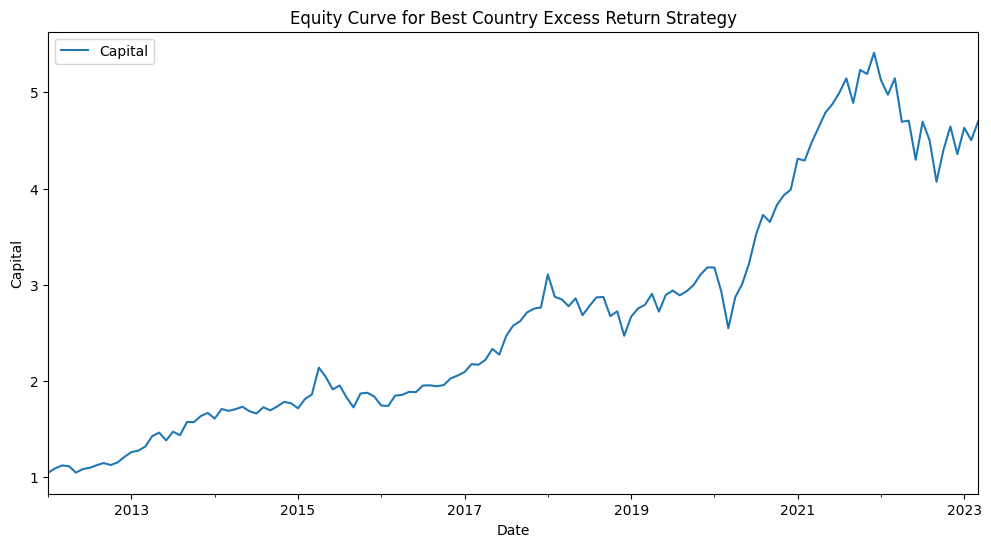

[*********************100%***********************]  5 of 5 completed


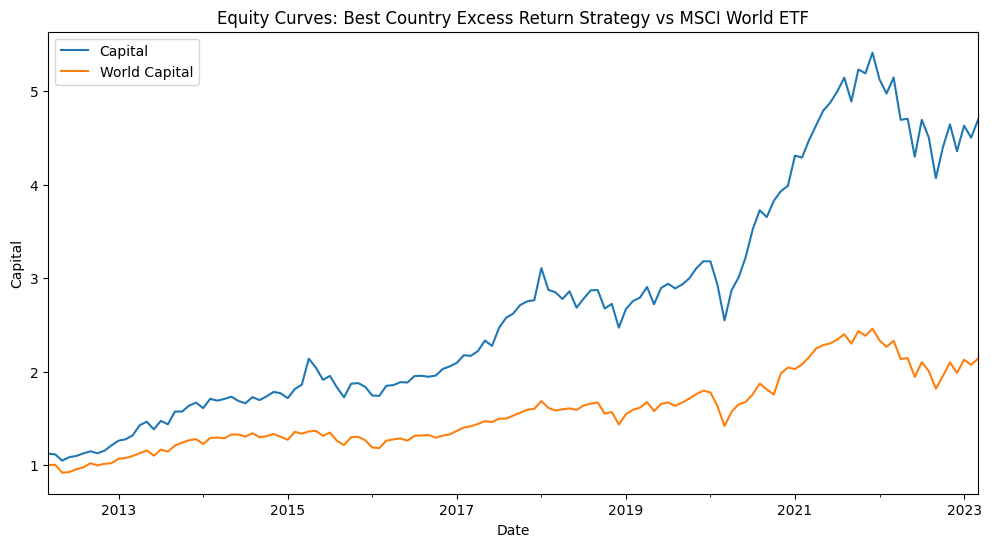

Best Country Excess Return Strategy Metrics:
Total Return: Capital    3.488365
dtype: float64
CAGR: Capital    0.142782
dtype: float64
Annualized Volatility: Capital    0.167882
dtype: float64
Sharpe Ratio: Capital    0.731358
dtype: float64
Max Drawdown: Capital   -0.247979
dtype: float64


MSCI World ETF Metrics:
Total Return: World Capital    1.139505
dtype: float64
CAGR: World Capital    0.070484
dtype: float64
Annualized Volatility: World Capital    0.145986
dtype: float64
Sharpe Ratio: World Capital    0.345816
dtype: float64
Max Drawdown: World Capital   -0.26138
dtype: float64


In [157]:
# Initialize variables for the backtest
capital = 1
transaction_fee = 0.001  # 0.1% fee
equity_curve = []
prev_best_idx = None

# Perform the backtest by iterating through each month
for date in excess_returns.index[12:]:
    best_idx = excess_returns.loc[date].idxmax()
    
    if prev_best_idx is None:
        prev_best_idx = best_idx
        
     # Skip the month if the best index is NaN
    if pd.isna(best_idx):
        continue

    # Apply transaction fee if switching to a different ETF
    if best_idx != prev_best_idx:
        capital *= (1 - transaction_fee)
        prev_best_idx = best_idx
    
    # Calculate the monthly return of the best ETF
    monthly_return = etf_monthly_returns.loc[date, best_idx]
    
    # Update capital
    capital *= (1 + monthly_return)
    equity_curve.append((date, capital))

# Convert the equity curve to a DataFrame
equity_curve_df = pd.DataFrame(equity_curve, columns=["Date", "Capital"]).set_index("Date")

# Plot the equity curve
equity_curve_df.plot(figsize=(12, 6))
plt.xlabel("Date")
plt.ylabel("Capital")
plt.title("Equity Curve for Best Country Excess Return Strategy")
plt.legend(loc="upper left")
plt.show()


# Add the MSCI World ETF ticker to the etf_tickers dictionary
etf_tickers["World"] = "URTH"

# Download historical data for the ETFs, including the MSCI World ETF
etf_data = yf.download(list(etf_tickers.values()), start=start_date, interval='1mo')['Close']

# Rename columns to match country names
etf_data.columns = etf_tickers.keys()

# Calculate the monthly returns for each country ETF, including the MSCI World ETF
etf_monthly_returns = etf_data.pct_change()

# Initialize variables for the MSCI World ETF equity curve
world_capital = 1
world_equity_curve = []

# Calculate the equity curve for the MSCI World ETF
for date, monthly_return in etf_monthly_returns['World'].items():
    if not pd.isna(monthly_return):
        world_capital *= (1 + monthly_return)
        world_equity_curve.append((date, world_capital))
        
world_equity_curve_df = pd.DataFrame(world_equity_curve, columns=["Date", "World Capital"]).set_index("Date")

# Merge the equity curves for the Best Country Excess Return Strategy and the MSCI World ETF
merged_equity_curves = equity_curve_df.merge(world_equity_curve_df, left_index=True, right_index=True)

# Plot the merged equity curves
merged_equity_curves.plot(figsize=(12, 6))
plt.xlabel("Date")
plt.ylabel("Capital")
plt.title("Equity Curves: Best Country Excess Return Strategy vs MSCI World ETF")
plt.legend(loc="upper left")
plt.show()

def calculate_metrics(equity_curve_df, risk_free_rate=0.02):
    # Compute the total return
    total_return = equity_curve_df.iloc[-1] / equity_curve_df.iloc[0] - 1

    # Compute the annualized return (CAGR)
    num_years = len(equity_curve_df) / 12
    annualized_return = (1 + total_return) ** (1 / num_years) - 1

    # Compute the annualized volatility
    annualized_volatility = equity_curve_df.pct_change().std() * np.sqrt(12)

    # Compute the Sharpe ratio
    sharpe_ratio = (annualized_return - risk_free_rate) / annualized_volatility

    # Compute the Maximum Drawdown
    drawdowns = (equity_curve_df / equity_curve_df.cummax()) - 1
    max_drawdown = drawdowns.min()

    return {
        'Total Return': total_return,
        'CAGR': annualized_return,
        'Annualized Volatility': annualized_volatility,
        'Sharpe Ratio': sharpe_ratio,
        'Max Drawdown': max_drawdown
    }

# Calculate performance metrics for the Best Country Excess Return Strategy
best_country_metrics = calculate_metrics(equity_curve_df)
print("Best Country Excess Return Strategy Metrics:")
for key, value in best_country_metrics.items():
    print(f"{key}: {value}")

print("\n")

# Calculate performance metrics for the MSCI World ETF
world_etf_metrics = calculate_metrics(world_equity_curve_df)
print("MSCI World ETF Metrics:")
for key, value in world_etf_metrics.items():
    print(f"{key}: {value}")

